# Apriori Analysis and Custom ANN

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import re
import csv
from sklearn.metrics import confusion_matrix

## Use Apriori analysis to find phrases, or interesting patterns in a novel.

Use the nltk library corpus gutenberg API and load the novel 'carroll-alice.txt' which is the
Alice in Wonderland by L. Carroll. There are 1703 sentences in the novel which can be
represented as 1703 transactions.

In [2]:
import nltk
from nltk.corpus import stopwords, gutenberg

nltk.download('stopwords', quiet=True)
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
    
stop_words = stopwords.words('english')
sentences = gutenberg.sents('carroll-alice.txt')
terms_sentences = []

# store unique words to save as features
unique_words = set()
for terms in sentences:
    terms = [w for w in terms if w not in stop_words]
    terms = [w for w in terms if re.search(r'^[a-zA-Z]{2}', w) is not None]
    terms_sentences.append(terms)
    unique_words.update(terms)

for sentence in terms_sentences[:5]:
    print(sentence)

['Alice', 'Adventures', 'Wonderland', 'Lewis', 'Carroll']
['CHAPTER']
['Down', 'Rabbit', 'Hole']
['Alice', 'beginning', 'get', 'tired', 'sitting', 'sister', 'bank', 'nothing', 'twice', 'peeped', 'book', 'sister', 'reading', 'pictures', 'conversations', 'use', 'book', 'thought', 'Alice', 'without', 'pictures', 'conversation']
['So', 'considering', 'mind', 'well', 'could', 'hot', 'day', 'made', 'feel', 'sleepy', 'stupid', 'whether', 'pleasure', 'making', 'daisy', 'chain', 'would', 'worth', 'trouble', 'getting', 'picking', 'daisies', 'suddenly', 'White', 'Rabbit', 'pink', 'eyes', 'ran', 'close']


In [3]:
print(f"There are {len(unique_words)} unique words")
unique_words = list(unique_words)

There are 2793 unique words


In [4]:
# transform the sentences to be True or '' for Weka framework
new_sentences = []
for sentence in terms_sentences:
    transformed = ['' for i in range(len(unique_words))]
    for idx, word in enumerate(unique_words):
        if word in sentence:
            transformed[idx] = 'True'
    new_sentences.append(transformed)

print(f"The length of the new sentences list is: {len(new_sentences)}")

The length of the new sentences list is: 1703


In [5]:
# write the sentences to a csv where each list (sentence) is a row and each term in the sentence in a column
with open('sentences.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_ALL, quotechar="'", lineterminator='\n')
    csvwriter.writerow(unique_words) 
    for sentence in new_sentences:
        csvwriter.writerow(sentence)

## Patterns Observed through Weka Analysis


### FPGrowth Algorithm with Default Parameters (`lowerBoundMinSupport = 0.1`)

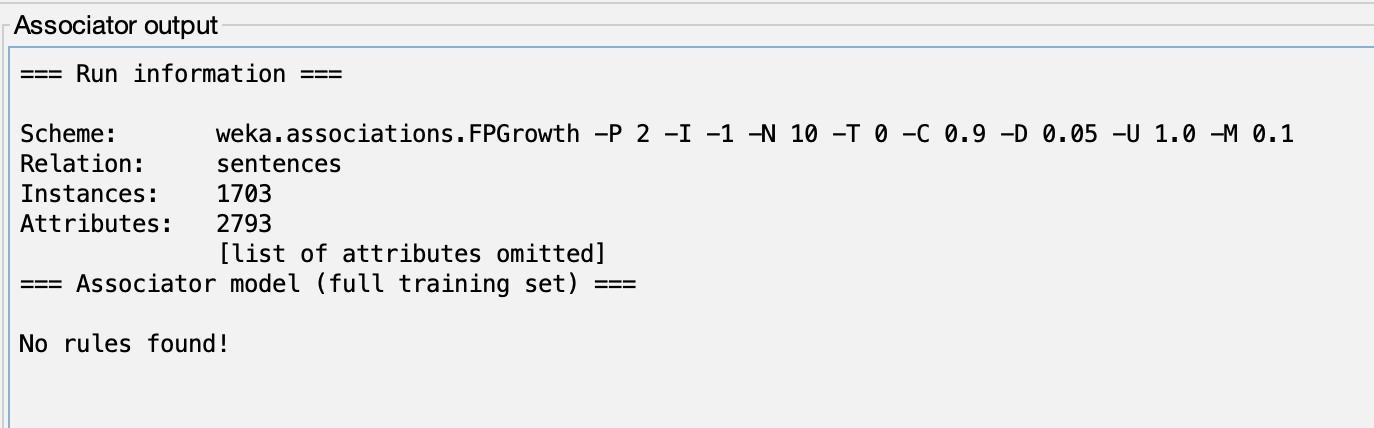

The `FPGrowth` algorithm with default parameters (`lowerBoundMinSupport = 0.1`) found `0` rules. Reducing the `lowerBoundMinSupport` will cause the algorithm to find more rules. 

### FPGrowth Algorithm with `lowerBoundMinSupport = 0.01`

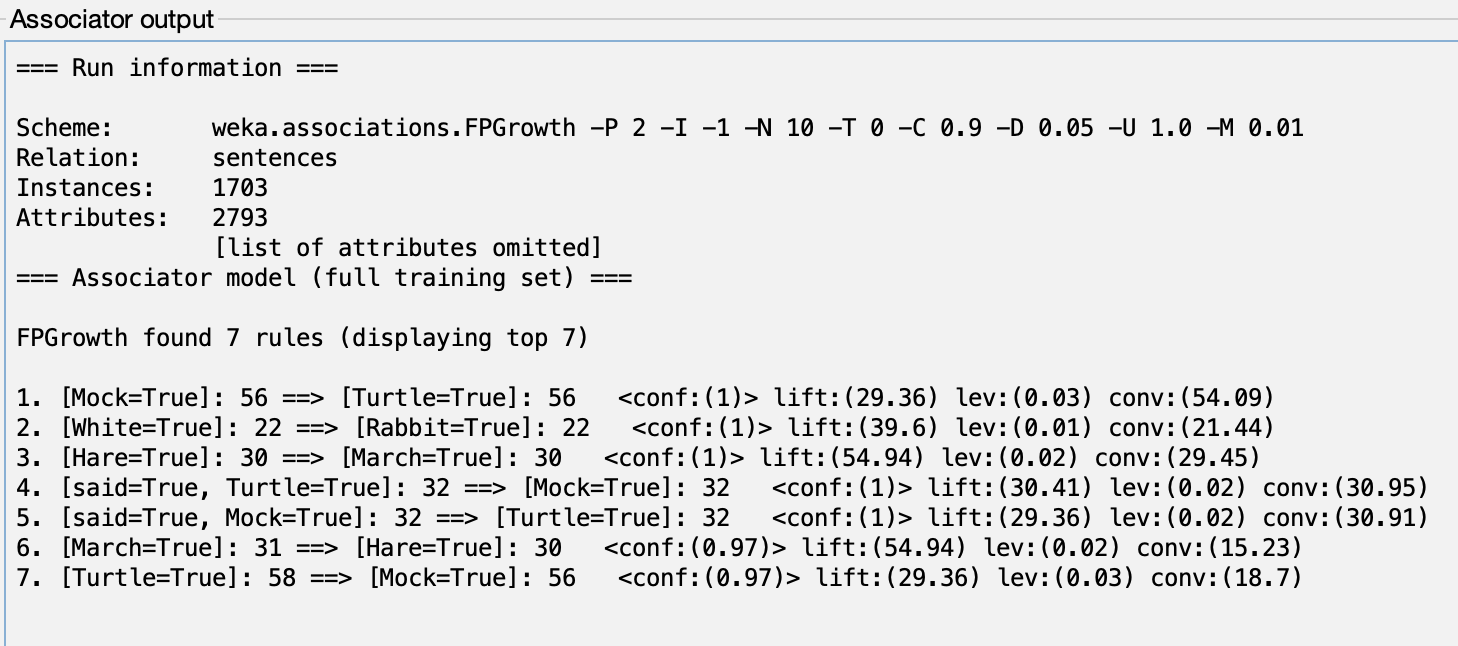

Reducing the `lowerBoundMinSupport` value to 0.01 found 7 rules. 

### FPGrowth Algorithm with `lowerBoundMinSupport = 0.005`

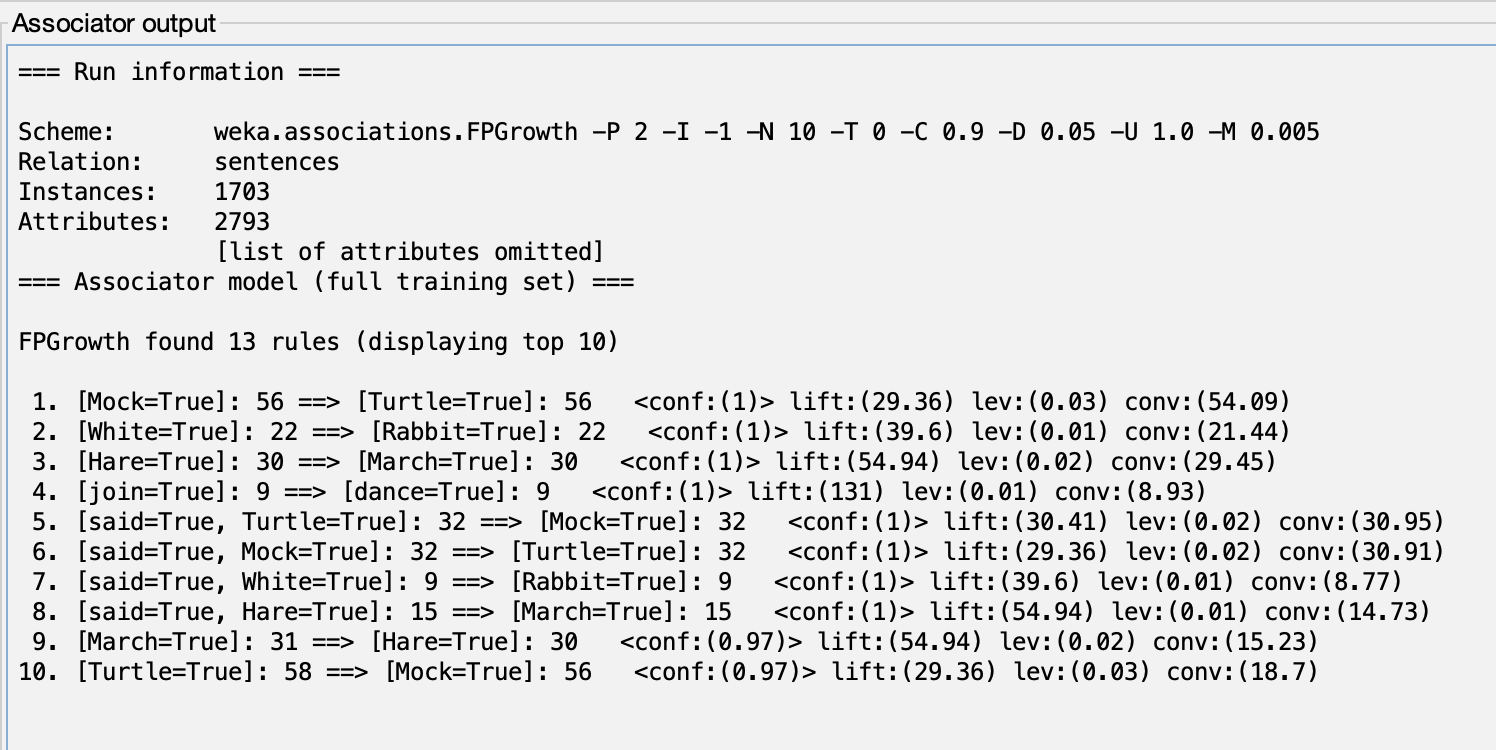

Reducing the `lowerBoundMinSupport` value to 0.005 found 13 rules.

### FPGrowth Algorithm with `lowerBoundMinSupport = 0.001`

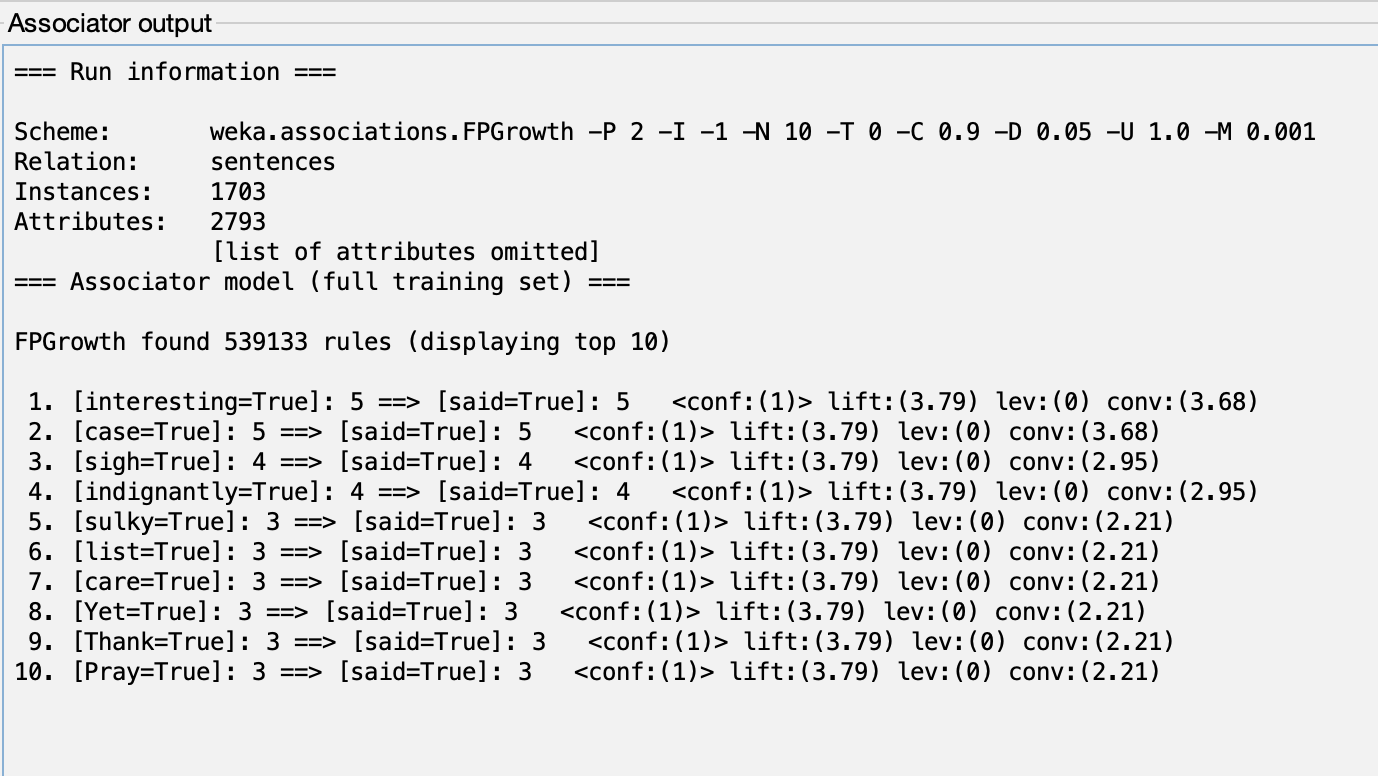

Reducing the `lowerBoundMinSupport` to 0.001 found 539133 rules.

The FPGrowth algorithm with a `lowerBoundMinsupport` value of `0.005` produced the best results. The top rules identified by this test happened more frequently than the test with a lower `lowerBoundMinSupport` value. The lift for these rules is also higher. The lift describes the likelihood of value y occurring when value x occurs. For example, the second rule states that there is a 39.6% likelihood of `Rabbit` occurring in a sentence where `White` occurs. Other common patterns are the word `Turtle` appearing in a sentence when the word `Mock` appears and the word `March` appearing in a sentence where `Hare` occurs. As shown in the results, the reverse of these rules is also true in the top 10 rules identified.

## Extend a custom single-layer neural network to support any number of hidden layers

In [6]:
# The following class was provided by E. Guven, module 11 notebook. 
# The subsequent cells will modify the code to have multiple hidden layers.
class NeuralNetMLP(object):

    def __init__(self, n_hidden=30, epochs=100, eta=0.001, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)  # used to randomize weights
        self.n_hidden = n_hidden # size of the hidden layer
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work
        self.w_out, self.w_h = None, None
    
    @staticmethod
    def onehot(_y, _n_classes):  # one hot encode the input class y
        onehot = np.zeros((_n_classes, _y.shape[0]))
        for idx, val in enumerate(_y.astype(int)):
            onehot[val, idx] = 1.0
        return onehot.T
    
    @staticmethod
    def sigmoid(_z):  # Eq 1
        return 1.0 / (1.0 + np.exp(-np.clip(_z, -250, 250)))

    def _forward(self, _X):  # Eq 2
        z_h = np.dot(_X, self.w_h)
        a_h = self.sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out)
        a_out = self.sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    @staticmethod
    def compute_cost(y_enc, output):  # Eq 4
        term1 = -y_enc * (np.log(output))
        term2 = (1.0-y_enc) * np.log(1.0-output)
        cost = np.sum(term1 - term2)
        return cost

    def predict(self, _X):
        z_h, a_h, z_out, a_out = self._forward(_X)
        ypred = np.argmax(z_out, axis=1)
        return ypred

    def fit(self, _X_train, _y_train, _X_valid, _y_valid):
        import sys
        n_output = np.unique(_y_train).shape[0]  # number of class labels
        n_features = _X_train.shape[1]
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        y_train_enc = self.onehot(_y_train, n_output)  # one-hot encode original y
        for ei in range(self.epochs):  # Ideally must shuffle at every epoch
            indices = np.arange(_X_train.shape[0])
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                z_h, a_h, z_out, a_out = self._forward(_X_train[batch_idx])  # neural network model
                
                sigmoid_derivative_h = a_h * (1.0-a_h)  # Eq 3
                delta_out = a_out - y_train_enc[batch_idx]  # Eq 5
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)  # Eq 6
                grad_w_out = np.dot(a_h.T, delta_out)  # Eq 7
                grad_w_h = np.dot(_X_train[batch_idx].T, delta_h)  # Eq 8
                self.w_out -= self.eta*grad_w_out  # Eq 9
                self.w_h -= self.eta*grad_w_h  # Eq 9

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(_X_train)
            cost = self.compute_cost(y_enc=y_train_enc, output=a_out)
            y_train_pred = self.predict(_X_train)  # monitoring training progress through reclassification
            y_valid_pred = self.predict(_X_valid)  # monitoring training progress through validation
            train_acc = ((np.sum(_y_train == y_train_pred)).astype(float) / _X_train.shape[0])
            valid_acc = ((np.sum(_y_valid == y_valid_pred)).astype(float) / _X_valid.shape[0])
            sys.stderr.write('\r%d/%d | Cost: %.2f ' '| Train/Valid Acc.: %.2f%%/%.2f%% '%
                (ei+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
        return self

### Run the neural network with one hidden layer on the Mnist dataset

In [7]:
# load mnist function from module 11 notebook
def load_mnist(path, kind='train'):
    from numpy import fromfile, uint8
    import os
    import struct
    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = fromfile(lbpath, dtype=uint8)
        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
            images = fromfile(imgpath, dtype=uint8).reshape(len(labels), 784)
            images = ((images / 255.) - .5) * 2
    return images, labels

x_train_mnist, y_train_mnist = load_mnist('../EP_datasets/mnist/', kind='train')
print(f'Train: Rows= {x_train_mnist.shape[0]}, columns= {x_train_mnist.shape[1]}')

x_test_mnist, y_test_mnist = load_mnist('../EP_datasets/mnist/', kind='t10k')
print(f'Test: Rows= {x_test_mnist.shape[0]}, Columns= {x_test_mnist.shape[1]}')

# Run the neural network with one hidden layer on the Mnist dataset
nn_1 = NeuralNetMLP(n_hidden=20, epochs=300, eta=0.0005, minibatch_size=100, seed=1)
# Run the neural network with one hidden layer on the Mnist dataset
nn_1.fit(x_train_mnist[:55000], y_train_mnist[:55000], x_train_mnist[55000:], y_train_mnist[55000:]);

Train: Rows= 60000, columns= 784
Test: Rows= 10000, Columns= 784


300/300 | Cost: 15436.03 | Train/Valid Acc.: 96.21%/95.50% 

The subsequent cell modifies the neural network class to work with a list of hidden layer sizes. Several changes must be made to the neural network to make it work with a list of hidden layer sizes instead of a single hidden layer size.

## Enhanced Multilayer Neural Network

Modifications:
- Modify the class definition to take a parameter `hidden_layer_sizes` representing a list of hidden layer sizes rather than the number of nodes for a single hidden layer.
- Modify the class weights to be a list of weights for all layers rather than `self.w_out, self.w_h `.
- Create an `_initialize_weights` method to initialize the weights for all hidden layers. 
- Modify the forward pass (`_forward`) to iterate through all weights/layers.
- Modify the `fit` and `predict` methods to take a list as the response from `_forward` and use the last element in the list (the output layer) to make the prediction. 
- Modify the backpropagation step in `_fit` to calculate `delta_out` for the output layer and then iterate through all hidden layer weights, using the weights from the previous layer (closest to the output layer) in subsequent calculations.
- Change the gradient updates to work for all layers.

In [8]:
class ModifiedNeuralNetMLP(object):

    def __init__(self, hidden_layer_sizes=[30], epochs=100, eta=0.001, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)  # used to randomize weights
        # MODIFIED: take a list of hidden layer sizes instead of one size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work
        # MODIFIED: changed this line to store a list of weights for all layers
        self.weights = []
    
    # ADDED: function to initialize weights for all hidden layers
    def _initialize_weights(self, n_features, n_output):
        self.weights = []
        # create the network topology where the firs layer is the number of features,
        # then the hidden layers of defined sizes, then the output layer of size num classes
        layer_sizes = [n_features] + self.hidden_layer_sizes + [n_output]
        # iterate through the layers in the network and initialize connecting weights. 
        for i in range(len(layer_sizes)-1):
            w = self.random.normal(loc=0.0, scale=0.1, size=(layer_sizes[i], layer_sizes[i+1]))
            self.weights.append(w)
            
    @staticmethod
    def onehot(_y, _n_classes):  # one hot encode the input class y
        onehot = np.zeros((_n_classes, _y.shape[0]))
        for idx, val in enumerate(_y.astype(int)):
            onehot[val, idx] = 1.0
        return onehot.T
    
    @staticmethod
    def sigmoid(_z):  # Eq 1
        return 1.0 / (1.0 + np.exp(-np.clip(_z, -250, 250)))
    
    # MODIFIED: forward now makes a forward pass through all layers
    def _forward(self, _X):  # Eq 2
        # start with the input data
        forward_pass = [_X]
        
        # MODIFIED: iterate through all layers
        # NOTE this code would need to change if using a different activation function for the 
        # output layer. The code provided in the module notebook was a simplified NN 
        # that used the same activation function for all layers.
        for w in self.weights:
            # calculate the dot product between the previous layer and the current weights
            z_h = np.dot(forward_pass[-1], w)
            a_h = self.sigmoid(z_h)
            forward_pass.append(a_h)

        return forward_pass

    @staticmethod
    def compute_cost(y_enc, output):  # Eq 4
        term1 = -y_enc * (np.log(output))
        term2 = (1.0-y_enc) * np.log(1.0-output)
        cost = np.sum(term1 - term2)
        return cost

    def predict(self, _X):
        # MODIFIED: to retrieve a list of activations for all
        ## layers and take the last value as the output layer
        forward_pass = self._forward(_X)
        ypred = np.argmax(forward_pass[-1], axis=1)
        return ypred

    def fit(self, _X_train, _y_train, _X_valid, _y_valid):
        import sys
        n_output = np.unique(_y_train).shape[0]  # number of class labels
        n_features = _X_train.shape[1]
 
        # MODIFIED: call the intialize weigths function to initialize weights for
        # all hidden layers
        self._initialize_weights(n_features, n_output)
        
        y_train_enc = self.onehot(_y_train, n_output)  # one-hot encode original y
        for ei in range(self.epochs):  # Ideally must shuffle at every epoch
            indices = np.arange(_X_train.shape[0])
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                # MODIFIED: Changed the backpropagation step to iterate through a list of layers and
                # activations from the forward pass. 
                forward_pass = self._forward(_X_train[batch_idx])  # neural network model
                
                # backward pass
                # compute delta for the output layer
                delta_out = forward_pass[-1] - y_train_enc[batch_idx]
                # store the errors for each layer
                deltas = [delta_out]
               
                # compute deltas for the hidden layers
                for layer in range(len(self.weights)-2, -1, -1):
                    sigmoid_derivative = forward_pass[layer + 1] * (1 - forward_pass[layer + 1])
                    delta = np.dot(deltas[-1], self.weights[layer + 1].T) * sigmoid_derivative
                    deltas.append(delta)
                    
                # reverse the deltas list to represent the true network
                # because the values were calculated in reverse
                deltas = deltas[::-1]
                
                # MODIFIED: update the gradients for all layers
                for layer in range(len(self.weights)):
                    grad = np.dot(forward_pass[layer].T, deltas[layer])  # Eq 7
                    self.weights[layer] -= self.eta * grad  # Eq 9

            # Evaluation after each epoch during training
            # MODIFIED: to get the list of activations from all layers
            # and take the last value as output
            forward_pass = self._forward(_X_train)
            cost = self.compute_cost(y_enc=y_train_enc, output=forward_pass[-1])
            y_train_pred = self.predict(_X_train)  # monitoring training progress through reclassification
            y_valid_pred = self.predict(_X_valid)  # monitoring training progress through validation
            train_acc = ((np.sum(_y_train == y_train_pred)).astype(float) / _X_train.shape[0])
            valid_acc = ((np.sum(_y_valid == y_valid_pred)).astype(float) / _X_valid.shape[0])
            sys.stderr.write('\r%d/%d | Cost: %.2f ' '| Train/Valid Acc.: %.2f%%/%.2f%% '%
                (ei+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
        return self

### Train the neural network with two hidden layers on the Mnist dataset

In [9]:
nn_2 = ModifiedNeuralNetMLP(hidden_layer_sizes=[20, 20], epochs=100, eta=0.0005, minibatch_size=100, seed=1)
# Run the neural network with two hidden layers on the Mnist dataset
nn_2.fit(x_train_mnist[:55000], y_train_mnist[:55000], x_train_mnist[55000:], y_train_mnist[55000:]);

100/100 | Cost: 13014.03 | Train/Valid Acc.: 96.73%/96.00% 

### Compare results on the test sets

In [10]:
y_pred = nn_1.predict(x_test_mnist)

print(f'Accuracy One Hidden Layer = {accuracy_score(y_test_mnist, y_pred)*100:.2f}%')
print(confusion_matrix(y_test_mnist, y_pred))

Accuracy One Hidden Layer = 94.12%
[[ 959    0    1    0    4    1    9    1    5    0]
 [   0 1100    3    2    1    0    5    1   23    0]
 [  14    0  961   13    4    0    9   11   20    0]
 [   2    3   13  955    0   13    1    7   10    6]
 [   0    2    2    1  937    1    5    6    4   24]
 [   8    5    2   39    6  775   13    9   27    8]
 [  13    4    4    0    6   14  903    1   13    0]
 [   3    6   13    7    3    0    0  980    4   12]
 [   3    4    6   12    9    6    5   11  915    3]
 [   4    5    0   17   24    4    1   21    6  927]]


In [11]:
y_pred = nn_2.predict(x_test_mnist)

print(f'Accuracy Two Hidden Layers = {accuracy_score(y_test_mnist, y_pred)*100:.2f}%')
print(confusion_matrix(y_test_mnist, y_pred))

Accuracy Two Hidden Layers = 95.03%
[[ 957    0    1    2    1    4    4    5    6    0]
 [   0 1105    3    2    0    1    4    4   16    0]
 [  12    0  969   10    6    1    3   14   17    0]
 [   3    0   13  962    0   10    0   11    9    2]
 [   1    1    7    0  936    0    5    3    5   24]
 [   4    2    2   18    2  830    5    5   17    7]
 [  10    4    3    0    8   14  909    0   10    0]
 [   1    4   12    8    2    1    0  983    5   12]
 [   6    2    6    4    8   11    6   14  911    6]
 [   3    4    0    6   24   10    2   11    8  941]]


The model with two hidden layers achieved slightly higher performance than the model with a single hidden layer. The model with two hidden layers converged in 100 iterations, and the model with one hidden layer converged in 300 iterations. Model two overshot the global minimum and began overfitting when training for more than 100 iterations. The subsequent cell tests a neural network with three hidden layers.

### Run a neural network with three hidden layers on the Mnist dataset

In [12]:
nn_3 = ModifiedNeuralNetMLP(hidden_layer_sizes=[20, 20, 20], epochs=100, eta=0.0005, minibatch_size=100, seed=1)
nn_3.fit(x_train_mnist[:55000], y_train_mnist[:55000], x_train_mnist[55000:], y_train_mnist[55000:]);

100/100 | Cost: 15207.66 | Train/Valid Acc.: 96.03%/94.80% 

In [13]:
y_pred = nn_3.predict(x_test_mnist)

print(f'Accuracy 3 Hidden Layers = {accuracy_score(y_test_mnist, y_pred)*100:.2f}%')
print(confusion_matrix(y_test_mnist, y_pred))

Accuracy 3 Hidden Layers = 93.97%
[[ 946    0    4    1    0   14   10    3    2    0]
 [   0 1107    3    1    3    1    2    1   16    1]
 [   6    2  948   20    2    9    9    5   30    1]
 [   0    0   11  950    0   12    0   11   21    5]
 [   0    0    2    0  927    3   16    3   11   20]
 [   6    1    6   34    1  818    4    2   16    4]
 [   8    4    8    0    7   12  910    2    7    0]
 [   0    1    6   17    4    1    0  968   13   18]
 [   2    3    6   24    6   10    3    9  909    2]
 [   3    3    0   13   41    7    2   16   10  914]]


The model with three hidden layers was too complex for this problem and overfit to the training data before reaching the same accuracy as the first two models. This model also had the lowest performance on the test data.

An optimization to the multilayer neural network above would be to take the activation function for each hidden layer as a parameter and have an additional parameter to specify the activation function for the output layer. Other optimizations could be to implement dropout layers or add support for regularization.